In [141]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pylab as plt
import rtsoft_lib as rt
import xgboost as xgb

from sklearn.metrics import mean_squared_error

DATA_PATH = "./data"

# Построение модели прогноза

### Загрузка данных (Не забудьте запустить в начале main_book.ipynb )

In [79]:
with open(os.path.join(DATA_PATH, "bdata_zip.plk"), 'rb') as f:
    bdata = pickle.load(f)
with open(os.path.join(DATA_PATH, "bdata_meters_zip.plk"), 'rb') as f:
    bdata_meters = pickle.load(f)

### Отфильтрованные данные (без аномалий, только рабочие дни, нужный дипозон по времени)

Load data
(21182, 154)
Len withot night hours:  14173
Russian holidays: {}
Len whithout weekends:  9931
2 Number of nan:  0
2 Number of nan:  2
2 Number of nan:  2


/home/maximus/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/maximus/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


2 Number of nan:  2


/home/maximus/Yandex.Disk/Arhipelag20.35/Hakaton_arhepilag/RTSoft.git/rtsoft_lib.py:104: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f1a1e26fc18> has a label of '_' which cannot be automatically added to the legend.
  axes[idx].legend(name)
/home/maximus/Yandex.Disk/Arhipelag20.35/Hakaton_arhepilag/RTSoft.git/rtsoft_lib.py:104: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f1a1e4b7668> has a label of '_' which cannot be automatically added to the legend.
  axes[idx].legend(name)
/home/maximus/Yandex.Disk/Arhipelag20.35/Hakaton_arhepilag/RTSoft.git/rtsoft_lib.py:104: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f1a1e292908> has a label of '_' which cannot be automatically added to the legend.
  axes[idx].legend(name)
/home/maximus/Yandex.Disk/Arhipelag20.35/Hakaton_arhepilag/RTSoft.git/rtsoft_lib.py:104: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f1a1e131e48> has a label of '_' which cannot be automatically added to t

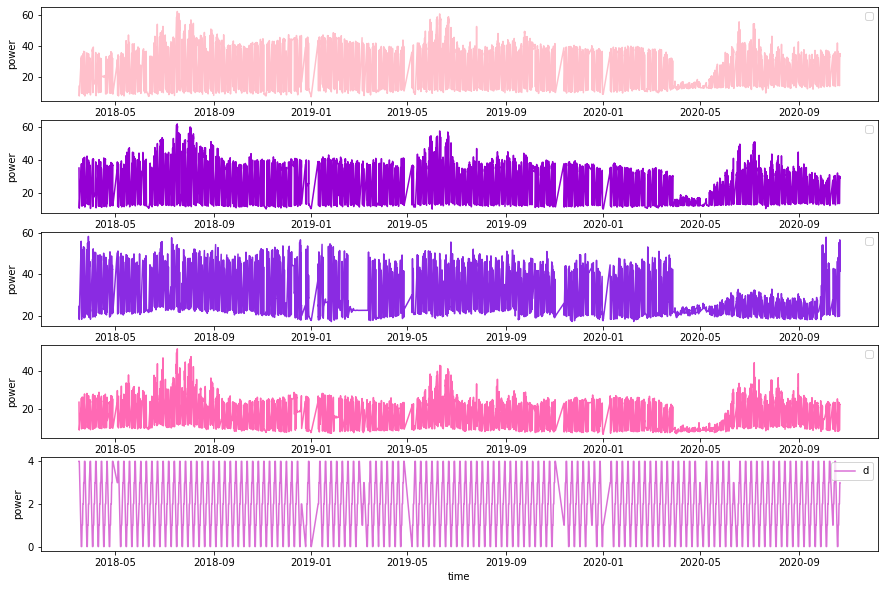

In [80]:
rt.add_total_power(bdata)
print("Load data")
print(bdata.shape)
t_indexes1 = rt.get_daytime_indexes(bdata)  #without nights
print('Len withot night hours: ', len(t_indexes1))
t_indexes2 = rt.get_without_weekends(bdata, t_indexes1) #without weekends
print('Len whithout weekends: ', len(t_indexes2))
bdata = rt.clear_anomaly(bdata)
bdata['dayofweek'] = rt.get_dayofweek_bdata(bdata)
name_cols =    rt.get_power_col_names() + ['dayofweek']
    
new_bdata = bdata.iloc[t_indexes1,:]
new_bdata  = new_bdata.iloc[t_indexes2, :]
rt.subplot_data(new_bdata, name_cols, figsize=(15,10))#, n, m)

In [153]:
new_bdata[rt.get_power_col_names()].head()

,_Bus_1_p_TM1H_mv_val,_Bus_2_p_TM1H_mv_val,_Bus_3_p_TM1H_mv_val,_Bus_4_p_TM1H_mv_val
0,NaN,35.021871,NaN,NaN
1,32.176472,33.457265,24.439199,23.505104
2,NaN,23.242523,22.388807,20.283791
3,13.661334,15.868997,20.720294,18.140407
4,11.391349,16.007367,20.323191,15.592572


### Формирование обучающей и валидационной выборки 

Отбросим NaN значения (три первых момента времени). Появились из-за не совсем  корректной работы функции для удаления аномалий.

In [6]:
# Диапозон для предсказания
#rt.UPPER_BOUND_HOUR=22 
#rt.LOWER_BOUND_HOUR=7
train_data = new_bdata[rt.get_power_col_names() + ['time']].iloc[3:-(rt.UPPER_BOUND_HOUR - rt.LOWER_BOUND_HOUR),:]

In [135]:
test_data = new_bdata[rt.get_power_col_names() + ['time']].iloc[-(rt.UPPER_BOUND_HOUR - rt.LOWER_BOUND_HOUR):,:]

In [21]:
window_size = (rt.UPPER_BOUND_HOUR - rt.LOWER_BOUND_HOUR)*5

In [97]:
def get_autoregress_data(train_data, window_size, predict_window = (rt.UPPER_BOUND_HOUR - rt.LOWER_BOUND_HOUR)):
    n = train_data.shape[0]
    mass = np.zeros([n - window_size - predict_window, window_size])
    y = np.zeros([n - window_size - predict_window, predict_window])
    j = 0
    for i in range(n - window_size - predict_window):
        mass[i,:] = train_data[i:i + window_size]
        for j in range(predict_window):
            y[i, j] = train_data[i + window_size + j]
    return mass, y

In [98]:
train, y = get_autoregress_data(train_data[col_name].values, window_size)

### Бустинг для временных рядов (нелинейная регрессия)

In [83]:

import lightgbm as lgb

params = {
    'learning_rate': 0.01,
    #'num_leaves': 80,
    'random_seed':666,
     #'num_leaves': 50, 
     #'bagging_freq': 5, 
     #'min_child_samples': 23, 
     #'min_data_in_leaf': 20,  
     #'feature_fraction': 0.4, 
     #'bagging_fraction': 0.9, 
     #'min_sum_hessian_in_leaf': 10,
     #'max_depth' : 8
    
}

In [110]:
class LGBoostRegression:
    def __init__(self, params):
        self.params = params
        self.size_predict = -1
    def fit(self, x_train, y_train):
        self.size_predict = y_train.shape[1]
        self.arr_models = []
        for i,y in enumerate(y_train.T):
            print(x_train.shape)
            print(y.shape)
            lgb_train = lgb.Dataset(x_train, y)
            model = lgb.train(self.params, lgb_train,\
                              verbose_eval=100,\
                              num_boost_round=20000)
            print('Train model {}'.format(i))
            self.arr_models.append(model)
            
    def predict(elf. x_test):
        y_res = []
        n = len(self.arr_models)
        if n>0:
            for i in range(n):
                y_res.append(self.arr_models[i].predict(x_test)[0])
    return y_res
            

In [111]:
%%time
est = LGBoostRegression(params)
est.fit(train, y)

(9823, 75)
(9823,)
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004130 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19125
[LightGBM] [Info] Number of data points in the train set: 9823, number of used features: 75
[LightGBM] [Info] Start training from score 25.927441
Train model 0
(9823, 75)
(9823,)
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006522 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19125
[LightGBM] [Info] Number of data points in the train set: 9823, number of used features: 75
[LightGBM] [Info] Start training from score 25.926651
Train model 1
(9823, 75)
(9823,)
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006181 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19125
[LightGBM] [Info] Numbe

In [142]:
# накосячил в функции predict в классе, пришлось данные извлекать отдельно
def predict(arr_models, x_test):
    y_res = []
    for i in range(len(arr_models)):
        y_res.append(arr_models[i].predict(x_test)[0])
    return y_res

In [143]:
y_predict = predict(est.arr_models, train_data[col_name].iloc[-window_size:])

/home/maximus/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:597: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


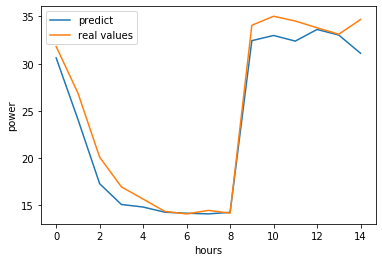

In [146]:
plt.plot(y_predict, label = 'predict')
plt.plot(test_data[col_name].values,label = 'real values')
plt.xlabel('hours')
plt.ylabel('power')
plt.legend()

### Результат

In [145]:
print('RMSE: ', mean_squared_error(test_data[col_name].values,y_predict))

RMSE:  3.0375214237415324
